## T1 simulation of the UK7T PSIR/MP2RAGE acquisition

The following notebook is designed to simulate the longitudinal magnetisation evolution during the PSIR/MP2RAGE acquisition. It loads the parameters for the UK7T parameters and simulate the signal across the whole Shot-to-Shot acquisition time. The timing is defined as in this paper (https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26061)


In [1]:
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt
import subprocess

## for debugging:
import time


In [2]:
## Tissue parameters:

# parameters for the simulation of the signal
T1tmp = 850 #ms
B1tmp = 100 #%

0.012486787878996002
0.019067868328276852
0.013341250740665809
0.01910636992550347
0.013336072845594947
0.019106136612577346
0.013336104222730934
0.01910613802641277
0.013336104032590987
0.019106138017845147


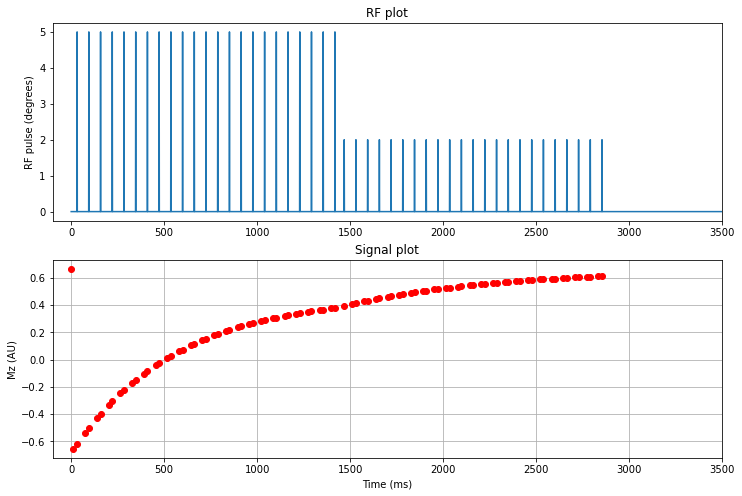

In [11]:
# Scanning parameters from the UK7T protocol:
SSi=3500 # TR between inversions
TR=6.3 # Echo spacing during the shot
TFE=224 # Number of shot per inversion
FAt1=5 # First flip angle
FAt2=2 # Second flip angle
TI1min=590 # Minimum TI for the first shot: need to compute
TI1_=725;# First Inversion Time
TIbis2=5; # Minimum TI for the second shot
TIbis=TI1_ + np.ceil(TFE/2*TR)+TIbis2; # timing for the middle of the sequence
TFE_bis=TFE/2


# Time sampling in 10th of ms
SSi10=SSi*10
T = np.arange(SSi10) # time variable
T0 = np.array(T)/10. # initial time variable
TR10=int(10*TR)
TR9=TR10-1 #TR minus one time tick...
TIbis10=int(TIbis*10)  # TIbisi
TI1_10=int(TI1_*10) # TI1a and TI1i
TI4_10=int(TIbis10+TI1_10) # TI4i

TI0_10=int(TI1_10-np.ceil(TFE_bis*TR10))
TI2_10=int(TI1_10+np.ceil(TFE_bis*TR10))
TI3_10=int(TI4_10-np.ceil(TFE_bis*TR10))
TI5_10=int(TI4_10+np.ceil(TFE_bis*TR10))       

if TI0_10<0:
    os.error('Error, wrong timing: please readjust sequence timing!')

# Create RF timing vector:
RF=np.zeros_like(T)#,dtype=bool)
for i in range(TI0_10,TI2_10,1):
    if not np.mod(i-TI0_10,TR10):       
        RF[i]=FAt1#True 
for i in range(TI3_10,TI5_10,1):
    if not np.mod(i-TI3_10,TR10):       
        RF[i]=FAt2#True 

        
plt.rcParams['figure.figsize'] = [12, 8]
fig1, (ax1) = plt.subplots(2,1)
ax1[0].plot(T0[0:SSi10:10],RF[0:SSi10:10])
ax1[0].set_title('RF plot')
#ax1[0].set_xlabel('Time (ms)')
ax1[0].set_xlim(-100,SSi)
ax1[0].set_ylabel('RF pulse (degrees)')

Mwm=0.71 # Proton density between WM and GM: no effect on the LUT
Mgm=0.8

FB=180 # Flip angle for the inversion
eff=0.95 # Efficiency of the adiabatic pulse
cosFB=np.cos(np.deg2rad(eff*FB))

expmT1=np.exp(-0.1/T1tmp)
expTRT1=np.exp(-(TR-0.1)/T1tmp)
Mwm0=Mwm*(1-np.exp(-SSi/T1tmp))

FA1=FAt1*B1tmp/100;cosFA1=np.cos(np.deg2rad(FA1));sinFA1=np.sin(np.deg2rad(FA1))
FA2=FAt2*B1tmp/100;cosFA2=np.cos(np.deg2rad(FA2));sinFA2=np.sin(np.deg2rad(FA2))

# Initialisation
M=np.ones((1,len(T)))*np.nan
M[0,0]=Mwm0

# 5 shots to be in steady-state:
# three generally suficient for most B1/T1 combination but 5 necessary for LUT
for shot in range(5):
    # Inversion first: taking into account efficiency and timing of the pulse (12ms)
    M[0,1]=cosFB*M[0,0]
    M[0,120]=M[0,1]
    # relaxation before acquisition
    M[0,TI0_10-1]=Mwm+(M[0,120]-Mwm)*np.exp(-(float(TI0_10-1-120)/10.)/T1tmp)

    i=TI0_10
    while i <= TI1_10:
        if RF[i]:
            M[0,i]=Mwm+(cosFA1*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
            i+=TR9

    # Signal in image 1
    INV1=sinFA1*M[0,TI1_10-1]
    print(INV1)

    i=TI1_10
    while i <= TI2_10:
        if RF[i]:
            M[0,i]=Mwm+(cosFA1*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
            i+=TR9  

    # relaxation between the two acquisition
    M[0,TI3_10-1]=Mwm+(M[0,TI2_10-1]-Mwm)*np.exp(-float(TI3_10-1-TI2_10)/10./T1tmp)

    i=TI3_10
    while i <= TI4_10:
        if RF[i]:
            M[0,i]=Mwm+(cosFA2*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
            i+=TR9

    # Signal in image 2
    INV2=sinFA2*M[0,TI4_10-1] 
    print(INV2)

    i=TI4_10
    while i <= TI5_10:
        if RF[i]:
            M[0,i]=Mwm+(cosFA2*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
            i+=1
        else:
            M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
            i+=TR9

    # relaxation after the second acquisition
    M[0,SSi10-1]=Mwm+(M[0,TI5_10-1]-Mwm)*np.exp(-(float(SSi10-1-TI5_10)/10.)/T1tmp)    

    # Reassignment of magnetisation for the start of the next shot
    M[0,0]=M[0,SSi10-1]

    
ax1[1].plot(T0[0:SSi10:10],M[0,0:SSi10:10],'ro')
ax1[1].set_title('Signal plot')
ax1[1].set_xlabel('Time (ms)')
ax1[1].set_ylabel('Mz (AU)')
ax1[1].set_xlim(-100,SSi)
ax1[1].grid(True)


# Calculating PSIR & MP2RAGE signals
PSIR = INV1/(abs(INV1)+abs(INV2))
MP2RAGE = INV1*INV2/(INV1**2+INV2**2)


In [4]:
print(PSIR)
print(MP2RAGE)

0.4110722067808412
0.46933733062320965
